# 08 - Getting and bias-correcting CMIP6 climate data

## Applying bias correction on climate model data to perform climate change impact studies on hydrology

This notebook will guide you on how to conduct bias correction of climate model outputs that will be fed as inputs to the hydrological model `Raven` to perform climate change impact studies on hydrology. 

## Geographic data
In this tutorial, we will be using the shapefile or GeoJSON file for watershed contours as generated in previous notebooks. The file can be uploaded to your workspace here and used directly in the cells below. In this notebook, we present a quick demonstration of the bias-correction approach on a small and predetermined dataset, but you can use your own basin according to your needs.

In [1]:
import xarray as xr
import datetime as dt
import xclim.sdba as sdba
import xclim
import gcsfs
import fsspec
import s3fs
import intake

from clisops.core import subset, average

## Application to a real catchment and test-case.
In this notebook, we will perform bias-correction on a real catchment using real data! You can change the input file for the contours, the catchment properties and other such parameters. The previous notebooks show how to extract basin area, latitude, and longitude, so use those to generate the required information if it is not readily available for your catchment.

Let's first start by providing some basic information:

- basin_contour: The shapefile or geojson of the watershed boundaries (if it is a shapefile, it has to be a zip-file containing the .shp, .shx and .prj files)
- reference_start_day: The start day of the reference period
- reference_end_day: The end day of the reference period
- future_start_day: The start day of the future period
- future_end_day: The end day of the future period
- climate_model: The name of the climate model. Must be selected from the available list for this notebook. However, if you want to use other data, the bias-correction step will still be applicable if you follow the same logic and formats as shown here.



In [20]:
basin_contour = 'input.geojson' # Can be generated using notebook "04_Delineating watersheds"

reference_start_day = dt.datetime(1980, 12, 31)
reference_end_day = dt.datetime(1991, 1, 1) # Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.
future_start_day = dt.datetime(2080, 12, 31)
future_end_day = dt.datetime(2091, 1, 1) # Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.

'''
Choose a climate model from the list below, which have the daily data required for Raven. Depending on the period required, it is possible that some
models will cause errors that need to be adressed specifically using date conversions. In those cases, please select another model or adjust the datetime
data to your needs.

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CESM2-WACCM
CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-g3
GFDL-CM4
GFDL-ESM4
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
'''

climate_model = 'MIROC6'


## Get CMIP6 data from the cloud

Accessing and downloading climate data can be a painful and time-consuming endeavour. PAVICS-Hydro provides a method to gather data quickly and efficiently, with as little user-input as possible. We use the PanGEO catalog for cloud climate data, and with a few simple keywords, we can automatically extract the required data from the climate model simulations. Furthermore, we can also automatically subset it to our precise location as defined by the watershed boundaries, and also extract only the time period of interest.

Let's start by opening the catalog of available data:



In [21]:
#Prepare the filesystem that allows reading data. Data is read on the Google Cloud Services, which host a copy of the CMIP6 (and other) data. 
fsCMIP = gcsfs.GCSFileSystem(token='anon', access='read_only')

#Get the catalog info from the pangeo dataset, which basically is a list of links to the various products.
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

#Print the contents of the catalog, so we can see the classification system
display(col)

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514961
dcpp_init_year,60


We can see that there are a lot of climate models (source_id), experiments, members, and other classifications. Let's see the list of available models, for example (source_id):

In [22]:
# Get the list of models. Replace "source_id" with any of the catalog categories (table_id, activity_id, variable_id, etc.)
list(col.df.source_id.unique())

['CMCC-CM2-HR4',
 'EC-Earth3P-HR',
 'HadGEM3-GC31-MM',
 'HadGEM3-GC31-HM',
 'HadGEM3-GC31-LM',
 'EC-Earth3P',
 'ECMWF-IFS-HR',
 'ECMWF-IFS-LR',
 'HadGEM3-GC31-LL',
 'CMCC-CM2-VHR4',
 'GFDL-CM4',
 'GFDL-AM4',
 'IPSL-CM6A-LR',
 'E3SM-1-0',
 'CNRM-CM6-1',
 'GFDL-ESM4',
 'GFDL-ESM2M',
 'GFDL-CM4C192',
 'GFDL-OM4p5B',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'CNRM-ESM2-1',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'MIROC6',
 'AWI-CM-1-1-MR',
 'EC-Earth3-LR',
 'IPSL-CM6A-ATM-HR',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1-HR',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'GISS-E2-1-G-CC',
 'UKESM1-0-LL',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'CanESM5',
 'CanESM5-CanOE',
 'INM-CM4-8',
 'INM-CM5-0',
 'NESM3',
 'MPI-ESM-1-2-HAM',
 'CAMS-CSM1-0',
 'MPI-ESM1-2-LR',
 'MPI-ESM1-2-HR',
 'MRI-AGCM3-2-H',
 'MRI-AGCM3-2-S',
 'MCM-UA-1-0',
 'INM-CM5-H',
 'KACE-1-0-G',
 'NorESM2-LM',
 'FGOALS-f3-H',
 'FGOALS-g3',
 'MIROC-ES2L',
 'FIO-ESM-2-0',
 'NorCPM1',
 'NorESM1-F',
 'MPI-ESM1-2-XR',
 'CESM1-1-CAM5-CMIP5',
 'E3SM-1-1',
 'KIOST

For this notebook, we will work with MIROC6, but you can use any other model from the list established previously.

Now, we can be more selective about what we want to get from the CMIP6 project data:

- source_id: The climate model, in this case 'MIROC6'
- experiment_id: The forcing scenario. Here we will use 'historical' (for the historical period) and for future data we could use any of the SSP simulations, such as 'ssp585' or 'ssp245'. 
- table_id: The timestep of the model simulation. Here we will use 'day' for daily data, but some models have monthly and 3-hourly data, for example.
- variable_id: The codename for the variable of interest. Here we will want 'tasmin', 'tasmax', and 'pr' for minimum temperature, maximum temperature and total precipitation, respectively.
- member_id: The code identifying the model member. Some models are run multiple times with varying initial conditions to represent natural variability. Here we will only focus on the first member 'r1i1p1f1'.

You can find more information about available data on the CMIP6 project webpage and [data nodes] (https://esgf-node.llnl.gov/projects/cmip6/).

Let's now see what the PanGEO catalog returns when we ask to filter according to all of these criteria:



In [23]:
# Build a query dictionary for all of our requests, for tasmin.
query = dict(experiment_id='historical',table_id='day',variable_id='tasmin',member_id='r1i1p1f1',source_id=climate_model)
col_subset = col.search(require_all_on=['source_id'], **query) # Command that will return the filtered list

# Show the filtered list:
display(col_subset.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MIROC,MIROC6,historical,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20191016


We can see that the list contains only one item: The daily tasmin variable, for the historical period of member r1i1p1f1 from the MIROC6 model, as requested! We can also see the path where that file resides on the "zstore", which is where it is stored on the Google Cloud service. We can now get the data:



In [24]:
# Get the object locator object
mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])

The final step is to open the dataset with xarray by using the 'open_zarr()' function. The following block performs multiple operations to get the data that we want:
    
- It opens the data using xarray
- It extracts only the times that we need for the reference/historical period
- It then subsets it spatially by getting only the points within the catchment boundaries. If your catchments is too small and this fails, try with a larger basin or apply a buffer around your boundaries.
- Since we are running a lumped model, it take the spatial average.
- It will then remove unnecessary coordinates that could cause problems later ('height', in this case)
- It will then rechunk the data into a format that makes it much faster to read and process

Finally, we will display the output of this entire process.


In [25]:
# Get the CMIP6 data from Google Cloud and read it in memory using xarray. This is done via "lazy loading" and is not actually reading the data in memory
# yet, but is keeping track of what it will need to get, eventually.
ds = xr.open_zarr(mapper, consolidated=True)

# Extract only the dates that we really want. Again, this is done via lazy loading, and is not actually using memory at this point.
ds = ds.sel(time=slice(reference_start_day,reference_end_day))

# Use the clisops subsetting tools to extract the data for the watershed boundaries and take the spatial average
ds = average.average_shape(ds, basin_contour)

# Correct the coordinates that are unnecessary for our variable
ds = ds.reset_coords('height',drop=True)

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
historical_tasmin = ds['tasmin'].chunk(-1)

# Show the end result!
display(historical_tasmin)

<xarray.DataArray 'tasmin' (time: 3653, geom: 1)>
dask.array<rechunk-merge, shape=(3653, 1), dtype=float32, chunksize=(3653, 1), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * time       (time) datetime64[ns] 1980-12-31T12:00:00 ... 1990-12-31T12:00:00
    lon        (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat        (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * geom       (geom) int64 0
    COAST      (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    DIST_MAIN  (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    PFAF_ID    (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    SIDE       (geom) object dask.array<chunksize=(1,), meta=np.ndarray>
    SORT       (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    SUB_AREA   (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    UP_AREA    (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    id         (geom) object dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K

We can see that we have a single chunk of 10 years of tasmin data, as expected! However, you might also have noticed that there is no metadata, such as units and variable properties left in the data array. We can fix that by wrapping the code in a block that forces xarray to keep the metadata. 

Also, since we will need to use this block of code for each variable, it might become tedious. Therefore, to simplify the code, we can combine everything into a single line, like this:
    
    

In [26]:
with xr.set_options(keep_attrs=True):
    historical_tasmin=average.average_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day)), basin_contour).reset_coords('height',drop=True)['tasmin'].chunk(-1)
    
display(historical_tasmin)

<xarray.DataArray 'tasmin' (time: 3653, geom: 1)>
dask.array<rechunk-merge, shape=(3653, 1), dtype=float32, chunksize=(3653, 1), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * time       (time) datetime64[ns] 1980-12-31T12:00:00 ... 1990-12-31T12:00:00
    lon        (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat        (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * geom       (geom) int64 0
    COAST      (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    DIST_MAIN  (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    PFAF_ID    (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    SIDE       (geom) object dask.array<chunksize=(1,), meta=np.ndarray>
    SORT       (geom) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    SUB_AREA   (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    UP_AREA    (geom) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    id         (geom) object dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K

Much better! we have all the information we need. Let's repeat the process for the 3 variables and for the reference and future periods using ssp585. You probably don't have to change anything in this following block of code, but you can taylor it to your needs knowing how everything is built now.

In [37]:
# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):

    # Load the files from the PanGEO catalogs, for reference and future variables of temperature and precipitation.
    out = {}
    for exp in ['historical','ssp585']:
        out[exp] = {}
        for variable in ['tasmin','tasmax','pr']:
            print(exp, variable)
            query = dict(experiment_id=exp, table_id='day', variable_id=variable, member_id='r1i1p1f1', source_id=climate_model)
            col_subset = col.search(require_all_on=['source_id'], **query)
            mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
            
            # special case for precipitation, which does not have the "height" variable that we need to discard as for tasmax and tasmin.
            if variable == 'pr':
                out[exp][variable] = average.average_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day))[variable], basin_contour).mean({'lat','lon'}).chunk(-1)
            else:
                out[exp][variable] = average.average_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day)).reset_coords('height',drop=True)[variable], basin_contour).mean({'lat','lon'}).chunk(-1)

# We can now extract the variables that we will need later:
historical_tasmax = out['historical']['tasmax']
historical_tasmin = out['historical']['tasmin']
historical_pr = out['historical']['pr']
future_tasmax = out['ssp585']['tasmax']
future_tasmin = out['ssp585']['tasmin']
future_pr = out['ssp585']['pr']



/tmp/ipykernel_2089/3810042736.py:35: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  historical_tasmin=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day)), basin_contour).mean({'lat','lon'}).reset_coords('height',drop=True)['tasmin'].chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")
/tmp/ipykernel_2089/3810042736.py:40: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  historical_tasmax=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day)), basin_contour).mean({'lat','lon'}).reset_coords('height',drop=True)['tasmax'].chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
  warni

<xarray.DataArray 'tasmax' (time: 3653)>
dask.array<rechunk-merge, shape=(3653,), dtype=float32, chunksize=(3653,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31T12:00:00 ... 1990-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Maximum Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K
    grid_mapping:   crs

In [38]:
display(historical_tasmax)

<xarray.DataArray 'tasmax' (time: 3653)>
dask.array<rechunk-merge, shape=(3653,), dtype=float32, chunksize=(3653,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31T12:00:00 ... 1990-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Maximum Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K
    grid_mapping:   crs

### Reference data to prepare bias correction
We have extracted the historical period and future period data from the GCM. Now we need the reference data to use as the baseline for bias-correction. Here we will use ERA5 and we will gather it again, since we can't be sure that the dates we selected in the 3rd notebook are still valid.



In [39]:
# Regenerate the ERA5 data to be sure. In an operational context, you could combine everything onto one notebook and ensure that the 
# dates and locations are constant!

#Configuration keys. Boilerplate, should not be changed.
CLIENT_KWARGS = {'endpoint_url': 'https://s3.wasabisys.com','region_name': 'us-east-1'}
CONFIG_KWARGS = {'max_pool_connections': 100}
STORAGE_OPTIONS = {'anon': True,'client_kwargs': CLIENT_KWARGS,'config_kwargs': CONFIG_KWARGS}
fsERA5 = fsspec.filesystem('s3', **STORAGE_OPTIONS)
mapper = fsERA5.get_mapper('s3://era5/world/reanalysis/single-levels/zarr-temporal/2021-06-30')

# Get the ERA5 data
with xr.set_options(keep_attrs=True):
    ERA5_reference=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_end_day)), basin_contour).mean({'latitude','longitude'})
    ERA5_tmin=ERA5_reference['t2m'].resample(time='1D').min().chunk(-1,-1,-1)
    ERA5_tmax=ERA5_reference['t2m'].resample(time='1D').max().chunk(-1,-1,-1)
    ERA5_pr=ERA5_reference['tp'].resample(time='1D').sum().chunk(-1,-1,-1)

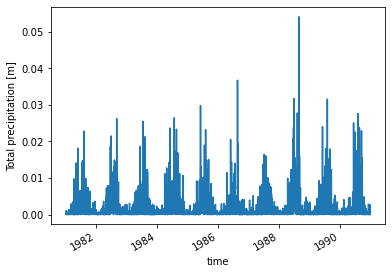

In [40]:
ERA5_pr.plot()

In [41]:
# Here we need to make sure that our units are all in the correct format. You can play around with the tools we've seen thus far to explore the units
# and make sure everything is consistent.

# Let's start with precipitation:
ERA5_pr = xclim.core.units.convert_units_to(ERA5_pr,'mm',context='hydro')
# The CMIP data is a rate rather than an absolute value, so let's get the absolute values:
historical_pr = xclim.core.units.rate2amount(historical_pr)
future_pr = xclim.core.units.rate2amount(future_pr)

# Now we can actually convert units in absolute terms.
historical_pr = xclim.core.units.convert_units_to(historical_pr,'mm',context='hydro')
future_pr = xclim.core.units.convert_units_to(future_pr,'mm',context='hydro')

# Now let's do temperature:
ERA5_tmin = xclim.core.units.convert_units_to(ERA5_tmin,'degC')
ERA5_tmax = xclim.core.units.convert_units_to(ERA5_tmax,'degC')
historical_tasmin = xclim.core.units.convert_units_to(historical_tasmin,'degC')
historical_tasmax = xclim.core.units.convert_units_to(historical_tasmax,'degC')
future_tasmin = xclim.core.units.convert_units_to(future_tasmin,'degC')
future_tasmax = xclim.core.units.convert_units_to(future_tasmax,'degC')

The model is now going to be trained to find correction factors between the reference dataset (observations) and historical dataset (climate model outputs for the same time period). The correction factors obtained are then applied to both reference and future climate outputs to correct them. This step is called the bias correction. In this test-case, we apply a method named `detrended quantile mapping`. 

Here we use the `xclim` utilities to bias-correct CMIP6 GCM data using ERA5 reanalysis data as the reference. See `xclim` documentation for more options! (https://xclim.readthedocs.io/en/stable/notebooks/sdba.html)

## WARNING: 
This following block of code will take a while to run, and some warning messages will appear during the process (related to longitude wrapping and other information on calendar types). Unless an error message appears, the code should run just fine!

In [42]:
# Use xclim utilities (sbda) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_pr, hist=historical_pr,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_precip = Adjustment.adjust(historical_pr, interp="linear")

# Apply the correction factors on the future period
corrected_fut_precip = Adjustment.adjust(future_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models
corrected_ref_precip=corrected_ref_precip.where(corrected_ref_precip>0, 0)
corrected_fut_precip=corrected_fut_precip.where(corrected_fut_precip>0, 0)

# Train the model to find the correction factors for the maximum temperature (tasmax) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmax, hist=historical_tasmax,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmax = Adjustment.adjust(historical_tasmax, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmax = Adjustment.adjust(future_tasmax, interp="linear")

# Train the model to find the correction factors for the minimum temperature (tasmin) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmin, hist=historical_tasmin,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmin = Adjustment.adjust(historical_tasmin, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmin = Adjustment.adjust(future_tasmin, interp="linear")

/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:114: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:114: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:114: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:114: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:114: UserWarning: Strange results could be returned w

The corrected reference and future data are then converted to netCDF files. This will take a while to run (perhaps a minute or two), since it will need to write the datasets to disk after having processed everything via lazy loading.

In [44]:
# Convert the reference corrected data into netCDF file
ref_dataset = xr.merge([
    corrected_ref_precip.to_dataset(name="pr"),
    corrected_ref_tasmax.to_dataset(name="tasmax"), 
    corrected_ref_tasmin.to_dataset(name="tasmin")
])
ref_dataset.to_netcdf("reference_dataset.nc")

# Convert the future corrected data into netCDF file
fut_dataset = xr.merge([
    corrected_fut_precip.to_dataset(name="pr"),
    corrected_fut_tasmax.to_dataset(name="tasmax"), 
    corrected_fut_tasmin.to_dataset(name="tasmin")
])
fut_dataset.to_netcdf("future_dataset.nc")

FSTimeoutError: 

In [ ]:
#Show the corrected future precipitation.
corrected_fut_precip.plot()

In [ ]:
# Compare it to the future precipitation without bias-correction.
future_pr.plot()